In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install pyod

     |████████████████████████████████| 102kB 2.6MB/s 
     |████████████████████████████████| 2.1MB 8.1MB/s 
  Created wheel for pyod: filename=pyod-0.7.8.2-cp36-none-any.whl size=104997 sha256=8b5cac11c642742e2dd1e61cab465a2900ed8f4e76869d56ff9d4423fcce9445
  Stored in directory: /root/.cache/pip/wheels/28/38/ec/0ecbcd67faeb595ac0dbd9b5f85d5c5bdcb4573819e65240fe
  Created wheel for combo: filename=combo-0.1.0-cp36-none-any.whl size=42043 sha256=eb303255aac98da98daa72e145fffdae54219a85b27ad023b48d29f7ba063787
  Stored in directory: /root/.cache/pip/wheels/00/fd/6c/8da495ef08ce61844a646df2423c2b8ecda377a89c90ecd88e
  Created wheel for suod: filename=suod-0.0.4-cp36-none-any.whl size=2167157 sha256=29ec609d7c585dd954c8912444f120beff8ffd8df429df899cb80912e90a146e
  Stored in directory: /root/.cache/pip/wheels/57/55/e5/a4fca65bba231f6d0115059b589148774b41faea25b3f2aa27
Successfully built pyod combo suod


In [3]:
!pip install suod 

In [4]:
%cd /content/drive/My\ Drive/TAA

/content/drive/My Drive/TAA


In [0]:
import scipy.io
mat = scipy.io.loadmat('satimage-2.mat')

In [0]:
X, y = mat['X'], mat['y']

In [0]:
y[y == 1] = -1
y[y == 0] = 1

In [8]:
from sklearn.svm import OneClassSVM
import time
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from pyod.models.knn import KNN
from pyod.models.ocsvm import OCSVM

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import  StandardScaler, MinMaxScaler

In [0]:
def evaluation_detection(ytrue,ypred):
  x1 = X_test[:,10]
  x2 = X_test[:,20]

  fig = plt.figure(figsize=(14,18))

  ax0 = fig.add_subplot(5,3,1)
  ax0.scatter(x1, x2, alpha=0.7, c=ytrue)
  ax0.set_title('Représentation des données selon le vrai label')
  ax0.set_xlabel('x1') 
  ax0.set_xlabel('x2') 

  ax1 = fig.add_subplot(5,3,2)
  colors = np.array(['#377eb8', '#ff7f00']) 
  ax1.scatter(x1, x2, alpha=0.5,  c=ypred)
  ax1.set_title('Représentation des données selon le label prédit')
  ax1.set_ylabel('x1')
  ax1.set_ylabel('x2')

  ax2 = fig.add_subplot(5,3,3)
  data = confusion_matrix(ytrue, ypred)
  labels = ['Outlier', 'Inliers']
  sns.heatmap(data, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Reds", ax=ax2) 
  ax2.set_title('Matrice de confusion')

  plt.tight_layout()
  plt.show()

In [0]:
def deep_predict(model,X_test):
  ypred = model.predict(X_test_scaled)
  mse = np.mean(np.power(X_test_scaled - ypred, 2), axis=1)
  df_error = pd.DataFrame({'reconstruction_error': mse})
  outliers = df_error.index[df_error.reconstruction_error > outlier_prop].tolist()
  y_pred = np.ones(len(y_test))
  y_pred[outliers] = -1
  return y_pred

In [0]:
#outlier_prop = len(y[y==-1])/len(y) #0.012
outlier_prop = 0.03

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [0]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [226]:
input_dim = X_train_scaled.shape[1]
encoding_dim = 10

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh",activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="tanh")(encoder)
encoder = Dense(int(2), activation="tanh")(encoder)
decoder = Dense(int(encoding_dim/ 2), activation='tanh')(encoder)
decoder = Dense(int(encoding_dim), activation='tanh')(decoder)
decoder = Dense(input_dim, activation='tanh')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

nb_epoch = 200
batch_size = 50
autoencoder.compile(optimizer='adam', loss='mse' )

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 36)                0         
_________________________________________________________________
dense_73 (Dense)             (None, 10)                370       
_________________________________________________________________
dense_74 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_75 (Dense)             (None, 2)                 12        
_________________________________________________________________
dense_76 (Dense)             (None, 5)                 15        
_________________________________________________________________
dense_77 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_78 (Dense)             (None, 36)                396

In [0]:
anomaly_algorithms = [
    ("Robust covariance", EllipticEnvelope(contamination=outlier_prop)),
    ("One-Class SVM", OneClassSVM(nu=outlier_prop, kernel="rbf", gamma=0.0001)),
    ("Isolation Forest", IsolationForest(n_estimators=300, max_samples = 600, contamination=outlier_prop, max_features=30, random_state=42)),
    ("KNN", KNN(contamination = outlier_prop, n_neighbors=30)),
    ("Deep MLP", autoencoder),
    ("Local Outlier Factor", LocalOutlierFactor(n_neighbors=15, contamination=outlier_prop))
    ]
algo_particuliers = ["KNN","Local Outlier Factor","Deep MLP"]

---------Robust covariance-----------


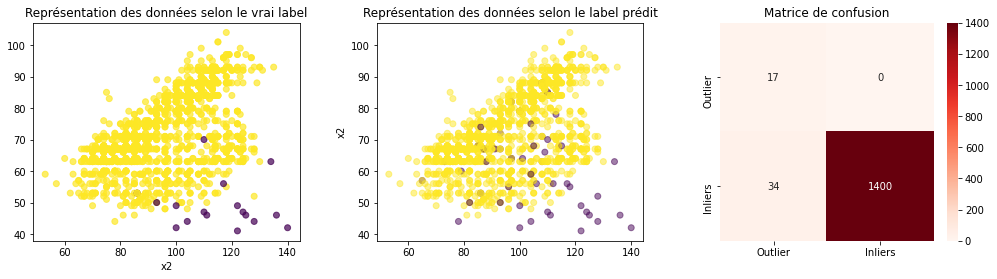

---------One-Class SVM-----------


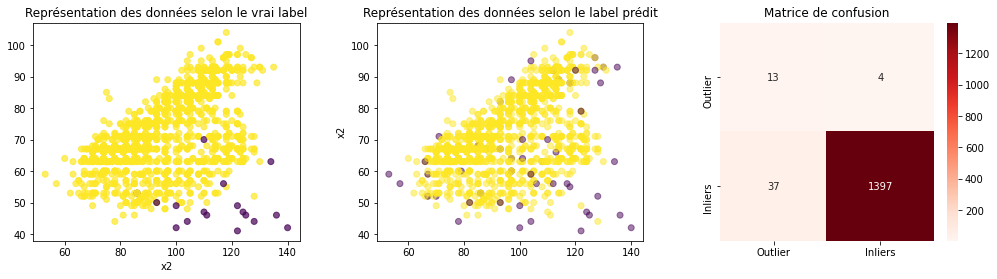

---------Isolation Forest-----------


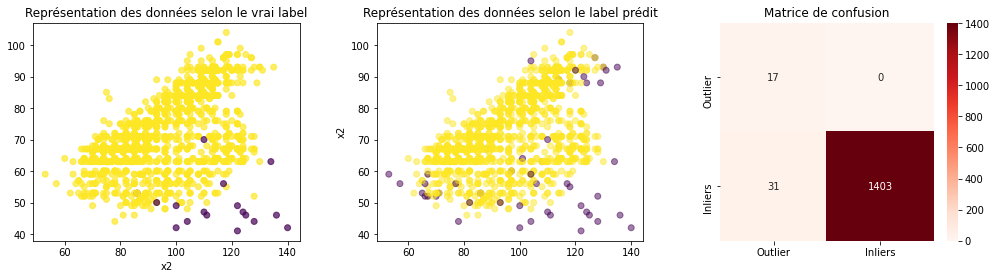

---------KNN-----------


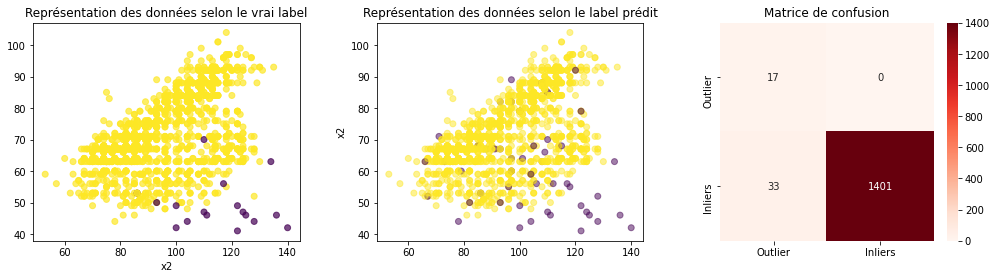

---------Deep MLP-----------


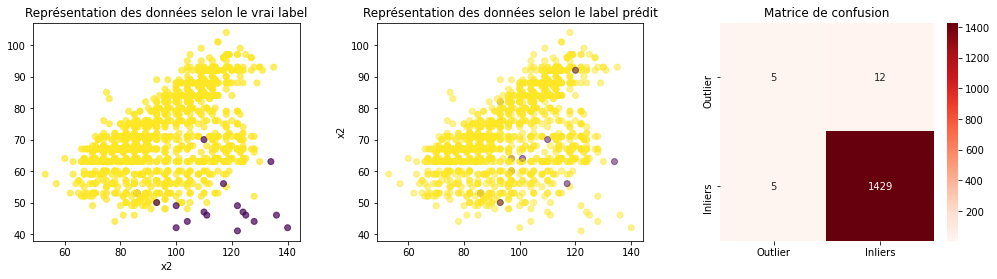

---------Local Outlier Factor-----------


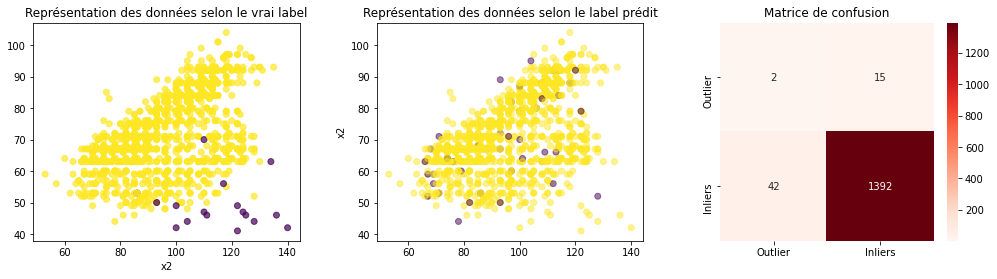

In [229]:
 for name, algorithm in anomaly_algorithms:
   if name == "KNN":
     algorithm.fit(X_train)
     y_pred = algorithm.predict(X_test)
     y_pred[y_pred == 1] = -1
     y_pred[y_pred == 0] = 1
     print('---------'+name+'-----------')
     evaluation_detection(y_test,y_pred)
   if name == "Local Outlier Factor":
     algorithm.fit(X_train)
     y_pred = algorithm.fit_predict(X_test)
     print('---------'+name+'-----------')
     evaluation_detection(y_test,y_pred)
   if name == "Deep MLP":
     algorithm.fit(X_train_scaled, X_train_scaled, epochs=nb_epoch,batch_size=batch_size,shuffle=True,validation_split=0.33, verbose=0)
     y_pred = deep_predict(algorithm,X_test_scaled)
     print('---------'+name+'-----------')
     evaluation_detection(y_test,y_pred)
   if name not in algo_particuliers:
     algorithm.fit(X_train)
     y_pred = algorithm.predict(X_test)
     print('---------'+name+'-----------')
     evaluation_detection(y_test,y_pred)
     